# Create Scatter Plots Showing Diversity in Heat Wave and Cold Snap Parameters


In [34]:
# Start by importing the packages we need:
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from datetime import timedelta


## Suppress Future Warnings


In [3]:
# Suppress future warnings:
warnings.simplefilter(action='ignore', category=FutureWarning)


## Set the Directory Structure

In [5]:
# Set the data input and output directories:
metadata_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/'
events_data_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/data/thermal_events_data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2026_tbd/figures/regional_results/'


## Create a Function to Plot the Diversity in Thermal Event Characteristics


In [85]:
def plot_hw_cs_data(region: int, hw_cs: str, events_data_input_dir: str, metadata_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the TPL-08 region name:
    nerc = pd.read_csv((metadata_input_dir + 'nerc_tpl08_region_names.csv'))
    nerc_name = nerc.loc[nerc['short_name'] == region, 'long_name'].item()
    
    # Extract the heat wave or cold snap library data for a given NERC region:
    if hw_cs == 'HW':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for region you want to use:
    subset_df = hw_cs_df[(hw_cs_df['Region'] == region)].copy()
    
    # Bin the regions impacted values and scale them for the scatter plot:
    subset_df['Regions_Impacted_Normalized'] = ((subset_df['Regions_Impacted'] - 1) / (subset_df['Regions_Impacted'].max() - 1)).round(2)

    # Set the rankings by temperature:
    if hw_cs == 'HW':
       subset_df = subset_df.sort_values('T_Max_Min', ascending=False)
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1
    if hw_cs == 'CS':
       subset_df = subset_df.sort_values('T_Max_Min')
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1    

    # Sort by date and reset the index:
    subset_df = subset_df.sort_values('Start')
    subset_df.reset_index(inplace=True, drop=True)
    
    # For cold snaps, shift the centroid date to plot whole winter seasons together:
    if hw_cs == 'CS':
       subset_df.loc[(subset_df['Center_DOY'] > 182), 'Center_DOY'] = subset_df['Center_DOY']-365

    # Set the plot parameters based on plotting heat waves or cold snaps:
    if hw_cs == 'HW':
       cmap = plt.get_cmap('Reds', 21)
       xticks = [121, 152, 182, 213, 244, 274]
       xticklabels = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
       xmin = 121
       xmax = 274 
       ylabel = 'Maximum Temperature [$^\circ$F]'
       title = ('Heat Wave Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df)))
    elif hw_cs == 'CS':
       cmap = plt.get_cmap('Blues', 21)
       xticks = [-61, -31, 1, 32, 60, 91]
       xticklabels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
       xmin = -61
       xmax = 91   
       ylabel = 'Minimum Temperature [$^\circ$F]'
       title = ('Cold Snap Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df)))

    # Identify the top-40 events based on the maximum or minimum event temperature:
    top40_events_df = subset_df.loc[(subset_df['T_Rank'] <= 40)].copy()
    nottop40_events_df = subset_df.loc[(subset_df['T_Rank'] > 40)].copy()
    
    # Make the scatter plot:
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True
    sc = plt.scatter(nottop40_events_df['Center_DOY'], nottop40_events_df['T_Max_Min'], s=(((nottop40_events_df['Regions_Impacted_Normalized']+0.1)*750)), c=nottop40_events_df['Duration'], 
                     edgecolors='k', linestyle='--', cmap=cmap, vmin=0, vmax=21)
    top40sc = plt.scatter(top40_events_df['Center_DOY'], top40_events_df['T_Max_Min'], s=(((top40_events_df['Regions_Impacted_Normalized']+0.1)*750)), c=top40_events_df['Duration'], 
                          edgecolors='k', linestyle='-', cmap=cmap, vmin=0, vmax=21, label='Size $\\propto$ # of NERC Regions Impacted')
    cbar = plt.colorbar(sc, ticks=[0, 7, 14, 21])
    cbar.ax.set_ylabel('Event Duration [Days]')
    plt.legend(loc='best', prop={'size': 18})
    plt.grid()
    plt.xticks(xticks, xticklabels)
    plt.xlim([xmin, xmax])
    plt.ylim([(subset_df['T_Max_Min'].min()-1.5), (subset_df['T_Max_Min'].max()+1.5)])
    plt.ylabel(ylabel)
    plt.title(title)

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + str(region) + '_' + hw_cs + '_Events.png'), dpi=image_resolution, bbox_inches='tight')
       plt.close()


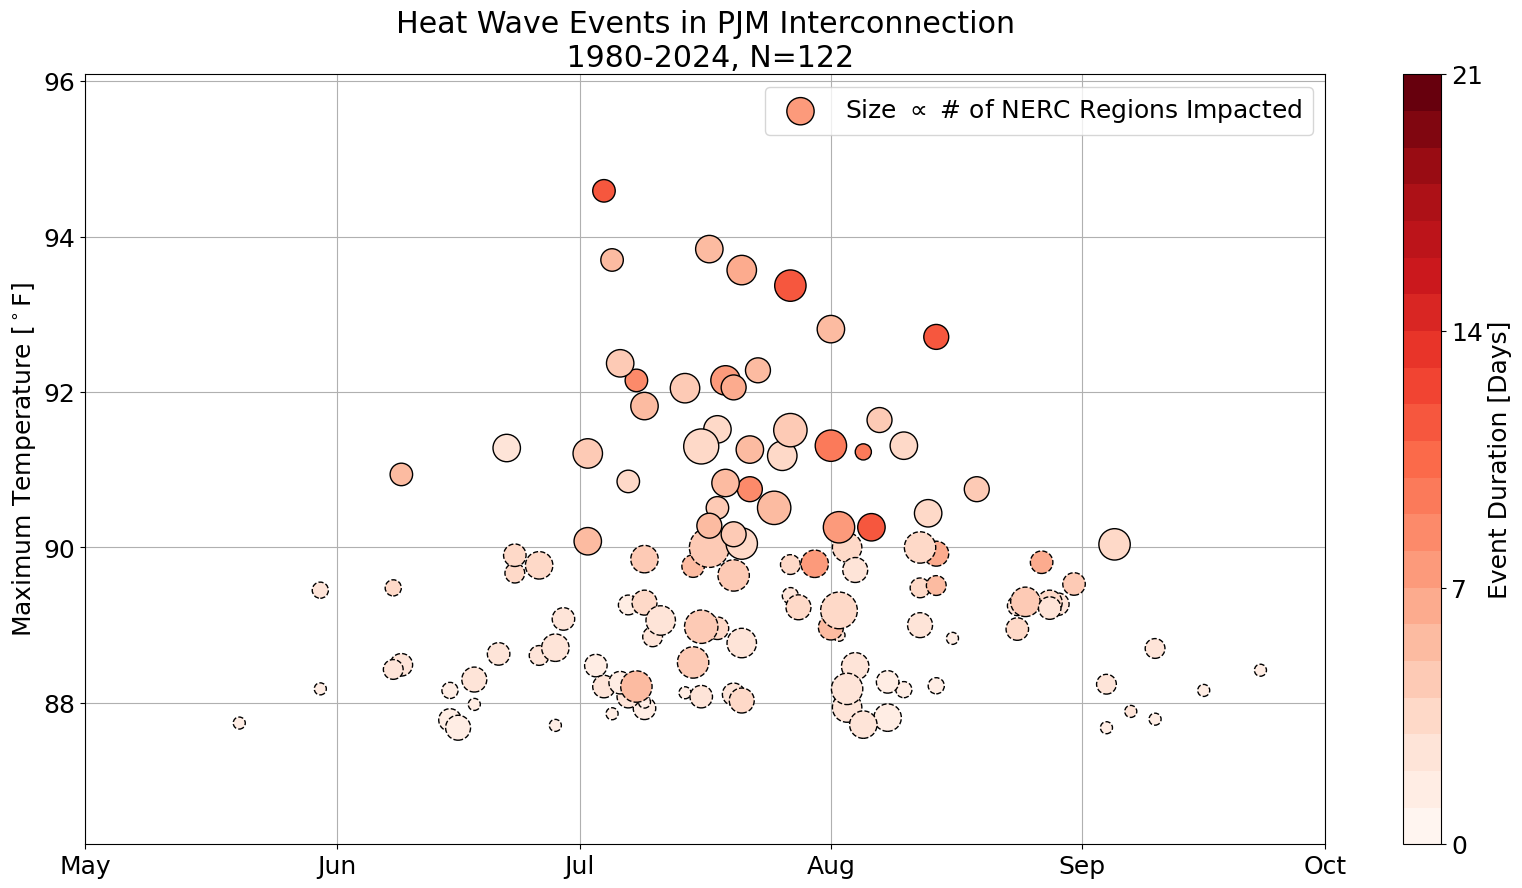

In [89]:
# Test the function:
plot_hw_cs_data(region = 'PJM',
                hw_cs = 'HW',
                events_data_input_dir = events_data_input_dir,
                metadata_input_dir = metadata_input_dir,
                image_output_dir = image_output_dir, 
                image_resolution = 150,
                save_images = False)


In [87]:
# Loop over the NERC TPL-008-1 regions and make the plot for each region:
for region in ['CA', 'ERCOT', 'FL', 'GB', 'ISONE', 'MISO-N', 'MISO-S', 'NYISO', 'PJM', 'PNW', 'RM', 'SERC', 'SPP-N', 'SPP-S', 'SW']:

    # Loop over heat wave and cold snap event types:
    for event_type in ['HW', 'CS']:
    
        # Make the plot:
        plot_hw_cs_data(region = region,
                        hw_cs = event_type,
                        events_data_input_dir = events_data_input_dir,
                        metadata_input_dir = metadata_input_dir,
                        image_output_dir = image_output_dir, 
                        image_resolution = 150,
                        save_images = True)


In [ ]:
def plot_hw_cs_data(region: int, hw_cs: str, events_data_input_dir: str, metadata_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in NERC region name file and extract the TPL-08 region name:
    nerc = pd.read_csv((metadata_input_dir + 'nerc_tpl08_region_names.csv'))
    nerc_name = nerc.loc[nerc['short_name'] == region, 'long_name'].item()
    
    # Extract the heat wave or cold snap library data for a given NERC region:
    if hw_cs == 'HW':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'hw_library_expanded.csv'))
    elif hw_cs == 'CS':
       hw_cs_df = pd.read_csv((events_data_input_dir + 'cs_library_expanded.csv'))

    # Subset to just the data for region you want to use:
    subset_df = hw_cs_df[(hw_cs_df['Region'] == region)].copy()
    
    # Bin the regions impacted values and scale them for the scatter plot:
    subset_df['Regions_Impacted_Normalized'] = ((subset_df['Regions_Impacted'] - 1) / (subset_df['Regions_Impacted'].max() - 1)).round(2)

    # Set the rankings by temperature:
    if hw_cs == 'HW':
       subset_df = subset_df.sort_values('T_Max_Min', ascending=False)
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1
    if hw_cs == 'CS':
       subset_df = subset_df.sort_values('T_Max_Min')
       subset_df['T_Rank'] = range(len(subset_df))
       subset_df['T_Rank'] = subset_df['T_Rank'] + 1    

    # Process the load data if the region is in the WECC:
    if region == 'CA' or region == 'PNW' or region == 'GB' or region == 'SW' or region == 'RM':
        
        # Set the rankings by WECC load peak:
        subset_df = subset_df.sort_values('WECC_Load_Peak_MWh', ascending=False)
        subset_df['WECC_Peak_Rank'] = range(len(subset_df))
        subset_df['WECC_Peak_Rank'] = subset_df['WECC_Peak_Rank'] + 1

        # Set the rankings by NERC TPL-008-1 region load peak:
        subset_df = subset_df.sort_values('Region_Load_Peak_MWh', ascending=False)
        subset_df['Region_Peak_Rank'] = range(len(subset_df))
        subset_df['Region_Peak_Rank'] = subset_df['Region_Peak_Rank'] + 1

        # Set the rankings by NERC TPL-008-1 region net load peak:
        subset_df = subset_df.sort_values('Region_Net_Load_Peak_MWh', ascending=False)
        subset_df['Region_Net_Peak_Rank'] = range(len(subset_df))
        subset_df['Region_Net_Peak_Rank'] = subset_df['Region_Net_Peak_Rank'] + 1

    else:
        subset_df['WECC_Peak_Rank'] = np.nan
        subset_df['Region_Net_Peak_Rank'] = np.nan
        subset_df['Region_Net_Peak_Rank'] = np.nan
        
    # Sort by date and reset the index:
    subset_df = subset_df.sort_values('Start')
    subset_df.reset_index(inplace=True, drop=True)
    
    # For cold snaps, shift the centroid date to plot whole winter seasons together:
    if hw_cs == 'CS':
       subset_df.loc[(subset_df['Center_DOY'] > 182), 'Center_DOY'] = subset_df['Center_DOY']-365

    # Set the plot parameters based on plotting heat waves or cold snaps:
    if hw_cs == 'HW':
       cmap = plt.get_cmap('Reds', 21)
       xticks = [121, 152, 182, 213, 244, 274]
       xticklabels = ['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct']
       xmin = 121
       xmax = 274 
       ylabel = 'Maximum Temperature [$^\circ$F]'
       title = ('Heat Wave Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df)))
    elif hw_cs == 'CS':
       cmap = plt.get_cmap('Blues', 21)
       xticks = [-61, -31, 1, 32, 60, 91]
       xticklabels = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
       xmin = -61
       xmax = 91   
       ylabel = 'Minimum Temperature [$^\circ$F]'
       title = ('Cold Snap Events in ' + nerc_name + '\n 1980-2024, N=' + str(len(subset_df)))

    # Identify the top-40 events based on the maximum or minimum event temperature:
    top40_events_df = subset_df.loc[(subset_df['T_Rank'] <= 40)].copy()
    nottop40_events_df = subset_df.loc[(subset_df['T_Rank'] > 40)].copy()
    
    # Make the scatter plot:
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = 18
    plt.rcParams['axes.axisbelow'] = True
    sc = plt.scatter(nottop40_events_df['Center_DOY'], nottop40_events_df['T_Max_Min'], s=(((nottop40_events_df['Regions_Impacted_Normalized']+0.1)*750)), c=nottop40_events_df['Duration'], 
                     edgecolors='k', linestyle='--', cmap=cmap, vmin=0, vmax=21)
    top40sc = plt.scatter(top40_events_df['Center_DOY'], top40_events_df['T_Max_Min'], s=(((top40_events_df['Regions_Impacted_Normalized']+0.1)*750)), c=top40_events_df['Duration'], 
                          edgecolors='k', linestyle='-', cmap=cmap, vmin=0, vmax=21, label='Size $\\propto$ # of NERC Regions Impacted')
    cbar = plt.colorbar(sc, ticks=[0, 7, 14, 21])
    cbar.ax.set_ylabel('Event Duration [Days]')
    plt.legend(loc='best', prop={'size': 18})
    plt.grid()
    plt.xticks(xticks, xticklabels)
    plt.xlim([xmin, xmax])
    plt.ylim([(subset_df['T_Max_Min'].min()-1.5), (subset_df['T_Max_Min'].max()+1.5)])
    plt.ylabel(ylabel)
    plt.title(title)

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + str(region) + '_' + hw_cs + '_Events.png'), dpi=image_resolution, bbox_inches='tight')

    return subset_df
    